# Sequential Bayesian Learning

<br><li>The sequential approach is to use the estimated posterior as a prior when the new data come.
<li>It's dependent on the assumption that the data is $i.i.d$.
<li>Applys the following:
    <ul>
        <li> Make use of observations one at a time or in small batches.
        <li> Can be used in real-time learning senarios (on-line)
        <li> After learning from observations (batch), we can discard it, so no need to store the whole data in memory.
    </ul><br>
<li>I'm going to utilise the linear basis function model because it's easier to visualise (same as the book).
<li>Assume:
    <ul> 
        <li> $y(X, W) = W_{0} + W_{1}X$
        <li>Because this has just two adaptive parameters, we can plot the prior and posterior distributions directly in parameter space. 
        <li> Data is generated from $f(x, a) = a_{0} +a_{1}x$ ,where $a_{0} = −0.3\;$ and $\;a_{1} = 0.5$ and $X$ ~ $ U(x|−1, 1)$.
        <li>Then evaluating $f(x_{n}, a)$, and finally adding Gaussian noise with standard deviation of 0.2 to obtain the target values tn
        <li>Our goal is to recover the values of a0 and a1 from such data
        <li> $\beta = 25$ and $\alpha = 2.0$.
    </ul>
<li>So, we do the same as previous bayesian leanining process, but we use the estimated posterior at each step as a prior to the next as new data is observed, and plot the posterior, the likelihood, and the data space at each step.


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import warnings

warnings.filterwarnings("ignore")

In [2]:
def simulator(f, sample_size, std, l=0, h=1):
    x = np.linspace(l, h, sample_size)
    np.random.shuffle(x)
    noise = np.random.normal(scale=std, size=x.shape)
    t = f(x) + noise
    return x.reshape(sample_size, -1), t

def f(x):
    return -0.3 + 0.5 * x

# generate data
def genrate_data(N_tr=10, N_ts=100, std=0.3, l=0, h=1):
    x_train, y_train = simulator(f, N_tr, std, l=l, h=h)
    x_test = np.linspace(l, h, N_ts)
    y_test = f(x_test)
    return x_train.reshape(N_tr, -1), y_train, x_test.reshape(N_ts, -1), y_test

In [3]:
class Sequential_Bayesian:
    def __init__(self, basis=None, beta:float=1.5, alpha:float=1.2, degree=None, b_mu=None, b_s=None):
        self.alpha = alpha
        self.beta = beta
        self.basis = basis
        self.degree = degree
        self.b_mu = b_mu
        self.b_s = b_s
        self.posterior = None
        self.prior = None
        self.train_iter = 0
#         self.m_N = None
#         self.S_N = None
        
    # get the basis of the input (Gaussian, Poly, Sigmoidal)
    def _basis(self, X):
        if isinstance(self.b_mu, int):
            self.b_mu = [self.b_mu] 
            
        X_trans = []
        if self.basis.lower()=='gauss':
            for m in self.b_mu:
                X_trans.append(np.exp(-0.5 * np.square(X - m)/self.b_s))

        elif self.basis.lower()=='poly':
            for i in range(0, self.degree+1):
                X_trans.append(X**i)

        elif self.basis.lower()=='sig':
            for m in self.b_mu:
                X_trans.append((np.tanh((X - m) / self.b_s) + 1 ) / 2)
        else:
            raise "Only Gauss, Poly, Sig"

        return np.atleast_2d(np.asarray(X_trans).squeeze().transpose())
#     .reshape(X.shape[0], -1)
#     .reshape(X.shape[0], -1)

    # get a uninformative prior
    def get_prior(self, m):
        self.S_0 = np.eye(m) * self.alpha
        self.m_0 = np.zeros((m, 1))
        return self.S_0, self.m_0
        
    # fit the data to get the m_N and S_N of the posterior
    def fit(self, X, y):
        
        if self.train_iter == 0:
            self.P = X.shape[1]
            self.S_N, self.m_N = self.get_prior(self.P + 1)
            self.posterior = multivariate_normal(mean=self.m_N.ravel(), cov=self.S_N)
            self.train_iter += 1
            return
        
        if self.basis:
            X = self._basis(X)
            
        self.N, self.P = X.shape
        
        # add cloumn of ones in X for the bias term
        X = np.append(X, np.ones((self.N, 1)), axis=1)
        y = y.reshape(self.N, 1)
        self.X_ = X
        
        #################
        # Get the prior #
        #################
        self.prior = multivariate_normal(mean=self.m_0.ravel(), cov=self.S_0)
        
        #############################
        # calculating the posterior #
        #############################
        # S_N = (S_0^-1 + B phi.T phi)^-1
        self.S_N = np.linalg.inv(np.linalg.inv(self.S_0) + self.beta * X.T.dot(X))
        self.m_N = self.S_N.dot(np.linalg.inv(self.S_0).dot(self.m_0) + self.beta * X.T.dot(y))  
        # The posterior
        self.posterior = multivariate_normal(mean=self.m_N.ravel(), cov=self.S_N)

        self.train_iter += 1
        
    # return the posterior predictive
    def posterior_predictive(self, X, std=False):

        if self.basis:
            X = self._basis(X)
        
        X = X.reshape(-1, self.P)
        X = np.append(X, np.ones((X.shape[0],1)), axis=1)
        
        self.W_M = X.dot(self.m_N).ravel()
        self.W_S = np.array(list(map(lambda x: x.dot(self.S_N).dot(x.T)+ self.beta, X)))                           
        Post_pred = multivariate_normal(mean=self.W_M.ravel(), cov=self.W_S)    
        return Post_pred
    
    def predict(self, X, samples=1, std=False):
        if self.basis:
            X = self._basis(X)
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
        W_samples = self.posterior.rvs(samples)
        preds = W_samples.T @ X.T
        self.pred_std = np.sqrt(1/self.beta + np.sum(X.dot(self.S_N).dot(X.T), axis=1))
        return preds

In [395]:
def multivariate_gaussian(pos, mu, cov):
    n = mu.shape[0]
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    N = np.sqrt((2*np.pi)**n * cov_det)
    # (x-mu)T Sigma-1 (x-mu)
    fac = np.einsum('...k,kl,...l->...', pos-mu, cov_inv, pos-mu)
    return np.exp(-fac / 2) / N

def plot_contour(dist, opt_w, ax):
    mu, cov = dist.mean, dist.cov
    r = np.linspace(-1, 1, 500)
    X, Y = np.meshgrid(r, r)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = multivariate_gaussian(pos, mu, cov)
    ax.scatter(opt_w[0], opt_w[1], s=50, marker='x', color='white')
    ax.contour(X, Y, Z, 100)
    return ax

def plot_likelihood(x, t, w_sample, opt_w, ax, title=False):
    r = np.linspace(-1.0, 1.0, 100)
    W1, W2 = np.meshgrid(r, r)
    pos = np.empty(W1.shape + (2,))
    pos[:, :, 0] = W1
    pos[:, :, 1] = W2
#     x_ = np.append(x, np.ones((x.shape[0],1)), axis=1)
    Z = multivariate_gaussian(pos, x_ @ w_sample, np.atleast_2d(1/np.sqrt(beta)))
    ax.contourf(W1, W2, Z, 50)    
    ax.scatter(opt_w[0], opt_w[1], s=50, marker='x', color='white')
    if title:
        ax.set_title('Likelihood function')
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    return ax

In [398]:
N=25
opt_w=[-0.3, 0.5]
beta=25.0; alpha=2.0; 
points = [0, 1, 2, 3, 5, N]
model = Sequential_Bayesian(beta=Beta, alpha=alpha)
X_train, y_train, X_test, y_test = genrate_data(N_tr=N, l=0, h=1, std=0.2)

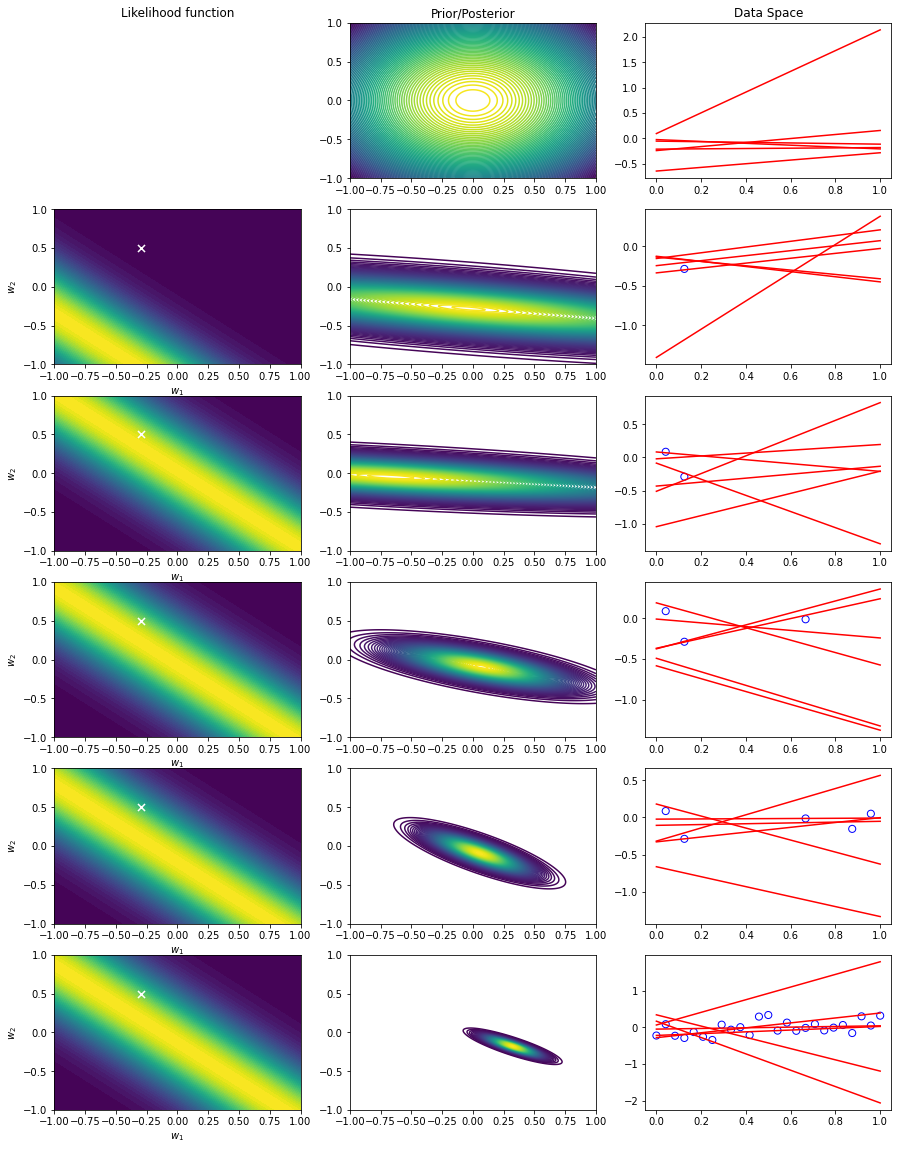

In [399]:
fig, axes = plt.subplots(len(points), 3, figsize=(15, 20));
for i in range(len(points)):
    s = None if i==0 else model.posterior.cov
    m = None if i==0 else model.posterior.mean
    # fit the model sequentially
    x = X_train[:points[i]]
    y = y_train[:points[i]]
    model.fit(x, y)
    pred_tr = model.predict(x)
    w_sample = model.posterior.rvs(1)
    # plot the data points
    axes[i][2].scatter(x, y, s=50, facecolor="none", edgecolor='blue')
    # plot the posterior contour
    plot_contour(model.posterior, opt_w, axes[i][1])
    if i==0:
        axes[i][0].axis('off')
        axes[i][0].set_title('Likelihood function')
        axes[i][1].set_title('Prior/Posterior')
        axes[i][2].set_title('Data Space')
    else:
        # plot the ikelihood
        plot_likelihood(x, pred_tr, w_sample, opt_w, axes[i][0])
    for i in range(6):
        pred = model.predict(X_test)
        axes[i][2].plot(X_test, pred, 'r')